# Contributions to global warming from individual greenhouse gases

Myles Allen -- myles.allen@ouce.ox.ac.uk

The following notebook calculates contributions to global temperature increase due to individual greenhouse gas emissions as reported in the Primap database Gütschow, J.; Günther, A.; Jeffery, L.; Gieseke, R. (2021): The PRIMAP-hist national historical emissions time series (1850-2018). v2.2. zenodo. https://doi.org/10.5281/zenodo.4479172

Calculations are all based on the linear response model documented in Myhre, G., D. Shindell, F.-M. Bréon, W. Collins, J. Fuglestvedt, J. Huang, D. Koch, J.-F. Lamarque, D. Lee, B. Mendoza, T. Nakajima, A. Robock, G. Stephens, T. Takemura and H. Zhang, 2013: Anthropogenic and Natural Radiative Forcing Supplementary Material. In: Climate Change 2013: The Physical Science Basis. Contribution of Working Group I to the Fifth Assessment Report of the Intergovernmental Panel on Climate Change [Stocker, T.F., D. Qin, G.-K. Plattner, M. Tignor, S.K. Allen, J. Boschung, A. Nauels, Y. Xia, V. Bex and P.M. Midgley (eds.)]. Available from https://www.ipcc.ch/report/ar5/wg1/chapter-8sm-anthropogenic-and-natural-radiative-forcing-supplementary-material/ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-whitegrid')
%matplotlib inline
colors=['#d62728', '#1f77b4', '#2ca02c', 'black']

In [2]:
def EFmod(nyr,a):
    Fcal = np.zeros((nyr,nyr)) # create linear operator to convert emissions to forcing
    time = np.arange(nyr+1)    # extend time array to compute derivatives
    F_0 = a[4]*a[13]*a[0]*time # compute constant term (if there is one, otherwise a[0]=0)
    for j in [1,2,3]:          # loop over gas decay terms to calculate AGWP using AR5 formula
        F_0=F_0+a[j]*a[4]*a[13]*a[j+5]*(1-np.exp(-time/a[j+5]))
    for i in range(0,nyr):     # first-difference AGWP to obtain AGFP
        Fcal[i,0]=F_0[i+1]-F_0[i]
    for j in range(1,nyr):     # build up the rest of the Toeplitz matrix
        Fcal[j:nyr,j]=Fcal[0:nyr-j,0]
    return Fcal

def FTmod(nyr,a):
    Tcal=np.zeros((nyr,nyr))   # create linear operator to convert forcing to warming
    time=np.arange(nyr)+0.5    # shift time array to compute derivatives
    for j in [0,1]:            # loop over thermal response times using AR5 formula
        Tcal[:,0]=Tcal[:,0]+(a[j+10]/a[j+15])*np.exp(-time/a[j+15])
    for j in range(1,nyr):     # build up the rest of the Toeplitz matrix
        Tcal[j:nyr,j]=Tcal[0:nyr-j,0]
    return Tcal

def ETmod(nyr,a):
    Tcal=np.zeros((nyr,nyr))   # create linear operator to convert emissions to warming
    time=np.arange(nyr)+1      # add one to the time array for consistency with AR5 formulae
    for j in [0,1]:            # loop over thermal response times using AR5 formula for AGTP
        Tcal[:,0]=Tcal[:,0]+a[4]*a[13]*a[0]*a[j+10]*(1-np.exp(-time/a[j+15]))
        for i in [1,2,3]:      # loop over gas decay terms using AR5 formula for AGTP
            Tcal[:,0]=Tcal[:,0]+a[4]*a[13]*a[i]*a[i+5]*a[j+10]*(np.exp(-time/a[i+5])-np.exp(-time/a[j+15]))/(a[i+5]-a[j+15])      
    for j in range(1,nyr):     # build up the rest of the Toeplitz matrix
        Tcal[j:nyr,j]=Tcal[0:nyr-j,0]
    return Tcal


In [3]:
# first set up AR5 model parameters, using syntax of FaIRv1.3 but units of GtCO2, not GtC
ny2=251
tim2=np.arange(ny2)+1

m_atm=5.1352*10**18 # AR5 official mass of atmosphere in kg
m_air=28.97*10**-3  # AR5 official molar mass of air
m_car=12.01*10**-3  # AR5 official molar mass of carbon
m_co2=44.01*10**-3  # AR5 official molar mass of CO2
m_ch4=16.043*10**-3 # AR5 official molar mass of methane
m_n2o=44.013*10**-3 # AR5 official molar mass of nitrous oxide

scl=1*10**3
a_ar5=np.zeros(20)

# Set to AR5 Values for CO2
a_ar5[0:4] = [0.21787,0.22896,0.28454,0.26863] #AR5 carbon cycle coefficients
a_ar5[4] = 1.e12*1.e6/m_co2/(m_atm/m_air)      # old value = 0.471 ppm/GtC # convert GtCO2 to ppm
a_ar5[5:9] = [1.e8,381.330,34.7850,4.12370]    #AR5 carbon cycle timescales
a_ar5[10:12] = [0.631,0.429]                   #AR5 thermal sensitivity coeffs
a_ar5[13] = 1.37e-2                            #AR5 rad efficiency in W/m2/ppm
a_ar5[14] = 0
a_ar5[15:17] = [8.400,409.5]                   #AR5 thermal time-constants -- could use Geoffroy et al [4.1,249.] 
a_ar5[18:21] = 0

ECS=3.0
a_ar5[10:12] *= ECS/np.sum(a_ar5[10:12])/3.7   # Rescale thermal sensitivity coeffs to prescribed ECS

# Set to AR5 Values for CH4
a_ch4=a_ar5.copy()
a_ch4[0:4]=[0,1.0,0,0]
a_ch4[4]=1.e12*1.e9/m_ch4/(m_atm/m_air)        # convert GtCH4 to ppb
a_ch4[5:9]=[1,12.4,1,1]                        # methane lifetime
a_ch4[13]=1.65*3.6324360e-4                    # Adjusted radiative efficiency in W/m2/ppb

# Set to AR5 Values for N2O
a_n2o=a_ar5.copy()
a_n2o[0:4]=[0,1.0,0,0]
a_n2o[4]=1.e12*1.e9/m_n2o/(m_atm/m_air)        # convert GtN2O to ppb
a_n2o[5:9]=[1,121.,1,1]                        # N2O lifetime
a_n2o[13]=(1.-0.36*1.65*3.63e-4/3.0e-3)*3.0e-3 # Adjusted radiative efficiency in W/m2/ppb

In [4]:
# Read in Primap data and create 1 Gt pulse & constant emissions
PR_input = pd.read_csv('PRIMAP-hist_v2.2_19-Jan-2021.csv')
PR_year=np.arange(2018-1850+1)+1850
nyr=np.shape(PR_year)[0]
E1=np.zeros([nyr,2])
E1[0,0]=1.
E1[:,1]=np.ones(nyr)

In [5]:
Fco2 = EFmod(nyr,a_ar5) # emissions to forcing for CO2
Fch4 = EFmod(nyr,a_ch4) # emissions to forcing for CH4
Fn2o = EFmod(nyr,a_n2o) # emissions to forcing for N2O
Tco2 = ETmod(nyr,a_ar5) # emissions to temperature for CO2
Tch4 = ETmod(nyr,a_ch4) # emissions to temperature for CH4
Tn2o = ETmod(nyr,a_n2o) # emissions to temperature for N2O
Fco2inv = np.linalg.inv(Fco2) # forcing to emissions for CO2
E1=np.zeros([nyr,2])
E1[0,0]=1.
E1[:,1]=np.ones(nyr)
# Compute forcing response
F1C=Fco2@E1
F1M=Fch4@E1
F1N=Fn2o@E1
# Calculate GWP_P and GWP_S
GWP_M=F1M/F1C
GWP_N=F1N/F1C
print('CH4 GWP20 & 100',GWP_M[[19,99],1] )
print('N2O GWP20 & 100',GWP_N[[19,99],1] )
# Compute temperature response
T1C=Tco2@E1
T1M=Tch4@E1
T1N=Tn2o@E1
# Calculate GTP_P and GTP_S
GTP_M=T1M/T1C
GTP_N=T1N/T1C
print('CH4 GTP20 & 100',GTP_M[[19,99],0] )
print('N2O GTP20 & 100',GTP_N[[19,99],0] )


CH4 GWP20 & 100 [83.64333008 28.40514574]
N2O GWP20 & 100 [262.98275058 264.05369631]
CH4 GTP20 & 100 [67.25156729  4.25941777]
N2O GTP20 & 100 [275.96382574 233.41175836]


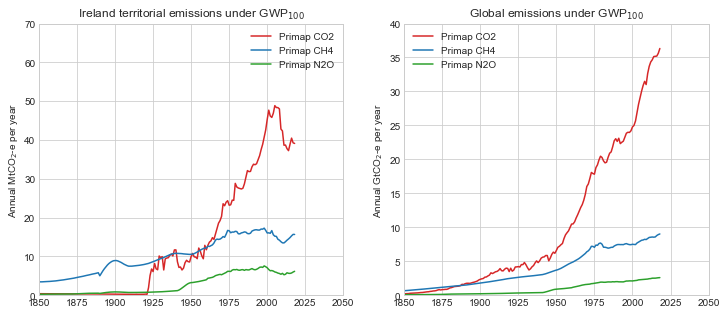

In [6]:
# input data and cross-check
# use AR5 GWP values
gwp=np.array([1.,28.,265.])
PR_country = 'IRL'
PG_country = 'EARTH'
PR_category = ['IPC1','IPC2','IPCMAG','IPC4']
PR_entity = ['CO2','CH4','N2O']
PR_scenario = 'HISTCR'

PR_year=np.arange(2018-1850+1)+1850
PR_ghgs=np.zeros([2018-1850+1,3])
PG_ghgs=np.zeros([2018-1850+1,3])
fg0 = plt.figure(figsize=[12,5])
ax0 = fg0.add_subplot(121)
ax0.axes.set_xlim([1850,2050])
ax0.axes.set_ylim([0.,70.])
ax0.set_ylabel('Annual MtCO$_2$-e per year')
ax0.set_title('Ireland territorial emissions under GWP$_{100}$')
for j in range(0,3):
    for i in range(0,4):
        selection = PR_input[(PR_input.country == PR_country)&\
                             (PR_input.category == PR_category[i])&\
                             (PR_input.entity == PR_entity[j])&\
                             (PR_input.scenario == PR_scenario)]
        individual_timeseries = selection[selection.scenario == PR_scenario].transpose()
        PR_ghgs[:,j] = PR_ghgs[:,j]+individual_timeseries.loc['1850':].values.squeeze()/1000.
    ax0.plot(PR_year,PR_ghgs[:,j]*gwp[j], label=('Primap '+PR_entity[j]), color=colors[j])
ax0.legend()
ax0 = fg0.add_subplot(122)
ax0.axes.set_xlim([1850,2050])
ax0.axes.set_ylim([0.,40.])
ax0.set_ylabel('Annual GtCO$_2$-e per year')
ax0.set_title('Global emissions under GWP$_{100}$')
for j in range(0,3):
    for i in range(0,4):
        selection = PR_input[(PR_input.country == PG_country)&\
                             (PR_input.category == PR_category[i])&\
                             (PR_input.entity == PR_entity[j])&\
                             (PR_input.scenario == PR_scenario)]
        individual_timeseries = selection[selection.scenario == PR_scenario].transpose()
        PG_ghgs[:,j] = PG_ghgs[:,j]+individual_timeseries.loc['1850':].values.squeeze()/1e6
    ax0.plot(PR_year,PG_ghgs[:,j]*gwp[j], label=('Primap '+PR_entity[j]), color=colors[j])
ax0.legend()

fg0.savefig("IRL_emissions.png",dpi=300)

In [7]:
# % reductions in methane and nitrous oxide emissions 2018-2030 from Ireland Article 23 submission
co21830=100*(38542.-27971.)/38542.
ch41830=100*(560.2-475.4)/560.2
n2o1830=100*(23.33-20.14)/23.33

# percentage reductions to 2030, CO2, methane & N2O
r30=np.array([co21830,ch41830,n2o1830])
print('Target CO2, CH4, N2O reductions to 2030',r30)
# percentage reductions to 2050, total, methane & N2O
r50=np.array([100.,r30[1]*(2050-2018)/(2030-2018),r30[2]*(2050-2018)/(2030-2018)])
print('Target ALL, CH4, N2O reductions to 2050',r50)
r30s=r30*51./23.

nyr=2050-1850+1
PR_2018_co2e=PR_ghgs[np.where(PR_year == 2018)]*gwp
PR_2030_co2e=PR_2018_co2e*(1.-r30/100.)
PS_2030_co2e=PR_2018_co2e*(1.-r30s/100.)
PR_2050_co2e=PR_2018_co2e*(1.-r50/100.)
PR_2050_co2e[0,0]=np.sum(PR_2018_co2e)*(1.-r50[0:1]/100.)-np.sum(PR_2050_co2e[0,1:3])
grds=np.zeros([2,3,2])
for j in range(3):
    grds[0,j,0]=(PR_2030_co2e[0,j]-PR_2018_co2e[0,j])/PR_2018_co2e[0,j]/(2030-2018)
    grds[1,j,0]=(PR_2050_co2e[0,j]-PR_2030_co2e[0,j])/PR_2018_co2e[0,j]/(2050-2030)
    grds[0,j,1]=(PS_2030_co2e[0,j]-PR_2018_co2e[0,j])/PR_2018_co2e[0,j]/(2030-2018)
    grds[1,j,1]=(PR_2050_co2e[0,j]-PS_2030_co2e[0,j])/PR_2018_co2e[0,j]/(2050-2030)
    
print('Calcd. CO2, CH4, N2O, ALL reductions to 2030',\
      1.-PR_2030_co2e/PR_2018_co2e,1.-np.sum(PR_2030_co2e)/np.sum(PR_2018_co2e))
print('Revsd. CO2, CH4, N2O, ALL reductions to 2030',\
      1.-PS_2030_co2e/PR_2018_co2e,1.-np.sum(PS_2030_co2e)/np.sum(PR_2018_co2e))
print('Calcd. CO2, CH4, N2O, ALL reductions to 2050',\
      1.-PR_2050_co2e/PR_2018_co2e,1.-np.sum(PR_2050_co2e)/np.sum(PR_2018_co2e))

PR_proj=np.ones([2050-2018+1,3,2])
y1=2030-2018+1
y2=2050-2018+1
for k in range(2):
    for j in range(3):
        PR_proj[0:y1,j,k]=1.+np.arange(y1)*grds[0,j,k]
        PR_proj[y1:y2,j,k]=PR_proj[y1-1,j,k]+(np.arange(y2-y1)+1)*grds[1,j,k]

# Use constant methane emissions & declining CO2 & N2O emissions past 2018 for global
GR_proj=np.ones([2050-2018+1,3])
GR_proj[0:y2,1]=1.-0.1*np.arange(y2)/(y2)
for j in [0,2]:
    GR_proj[0:y2,j]=1.-np.arange(y2)/(y2)


Target CO2, CH4, N2O reductions to 2030 [27.42722225 15.13745091 13.67338191]
Target ALL, CH4, N2O reductions to 2050 [100.          40.36653576  36.46235176]
Calcd. CO2, CH4, N2O, ALL reductions to 2030 [[0.27427222 0.15137451 0.13673382]] 0.22873178816328765
Revsd. CO2, CH4, N2O, ALL reductions to 2030 [[0.60816884 0.33565652 0.30319238]] 0.5071878781012034
Calcd. CO2, CH4, N2O, ALL reductions to 2050 [[1.33939014 0.40366536 0.36462352]] 1.0


In [8]:
# compute country territorial emissions to remove from baseline
CT_ghgs=np.zeros([2050-1850+1,3,2])
GT_ghgs=np.zeros([2050-1850+1,3])
CT_year=np.arange(2050-1850+1)+1850
for j in range(3):
    for k in range(2):
# Use Primap emissions pre-2018
        CT_ghgs[np.where((CT_year >= 1850) & (CT_year < 2018)),j,k]=PR_ghgs[np.where(PR_year < 2018), j]
# Use exponential pre-1925 
        CT_ghgs[np.where((CT_year < 1925)),j,k] = PR_ghgs[np.where(PR_year == 1925), j]*\
                                                  np.exp((CT_year[np.where(CT_year < 1925)]-1925)/50)
# Use linear projections past 2018 
        CT_ghgs[np.where((CT_year >= 2018)),j,k]=PR_ghgs[np.where(PR_year == 2018), j]*PR_proj[:,j,k]
# Use Primap emissions pre-2018 for global
    GT_ghgs[np.where((CT_year >= 1850) & (CT_year < 2018)),j]=PG_ghgs[np.where(PR_year < 2018), j]
# Use constant methane & declining CO2 & N2O emissions past 2018 for global
    GT_ghgs[np.where((CT_year >= 2018)),j]=PG_ghgs[np.where(PR_year == 2018), j]*GR_proj[:,j]



In [9]:
CT_temp=np.zeros([CT_ghgs.shape[0],4,2])
for k in range(2):
    CT_temp[:,0,k]=ETmod(nyr,a_ar5)@CT_ghgs[:,0,k]
    CT_temp[:,1,k]=ETmod(nyr,a_ch4)@CT_ghgs[:,1,k]
    CT_temp[:,2,k]=ETmod(nyr,a_n2o)@CT_ghgs[:,2,k]
    CT_temp[:,3,k]=np.sum(CT_temp[:,0:3,k],axis=1)
GT_temp=np.zeros([CT_ghgs.shape[0],4])
GT_temp[:,0]=ETmod(nyr,a_ar5)@GT_ghgs[:,0]
GT_temp[:,1]=ETmod(nyr,a_ch4)@GT_ghgs[:,1]
GT_temp[:,2]=ETmod(nyr,a_n2o)@GT_ghgs[:,2]
GT_temp[:,3]=np.sum(GT_temp[:,0:3],axis=1)
CT_rate=np.gradient(CT_temp,axis=0)
GT_rate=np.gradient(GT_temp,axis=0)
print('Ireland 2018 warming (mK)',CT_temp[np.where(CT_year == 2018),3,0])
print('Earth   2018 warming  (K)',GT_temp[np.where(CT_year == 2018),3])
print('Ireland 1990 warming (mK)',CT_temp[np.where(CT_year == 1990),3,0])
print('Earth   1990 warming  (K)',GT_temp[np.where(CT_year == 1990),3])
print('Ireland 2016 warming (mK)',CT_temp[np.where(CT_year == 2016),3,0])
print('Earth   2016 warming  (K)',GT_temp[np.where(CT_year == 2016),3])
print('Ireland 2020 warming (mK)',CT_temp[np.where(CT_year == 2020),3,0])
print('Ireland max  warming (mK)',np.max(CT_temp[:,3,0]),CT_year[np.argmax(CT_temp[:,3,0])])
print('Revised max  warming (mK)',np.max(CT_temp[:,3,1]),CT_year[np.argmax(CT_temp[:,3,1])])


Ireland 2018 warming (mK) [[2.10908499]]
Earth   2018 warming  (K) [[1.20672778]]
Ireland 1990 warming (mK) [[1.41250426]]
Earth   1990 warming  (K) [[0.73022457]]
Ireland 2016 warming (mK) [[2.06662618]]
Earth   2016 warming  (K) [[1.16521066]]
Ireland 2020 warming (mK) [[2.15154948]]
Ireland max  warming (mK) 2.4124909876727827 2041
Revised max  warming (mK) 2.292781141392907 2034


2021 population fraction: 0.6331428571428571
Contribution to warming 2018: [[1.74777197]]
Contribution to warming rate 2018: [[1.0170064]]


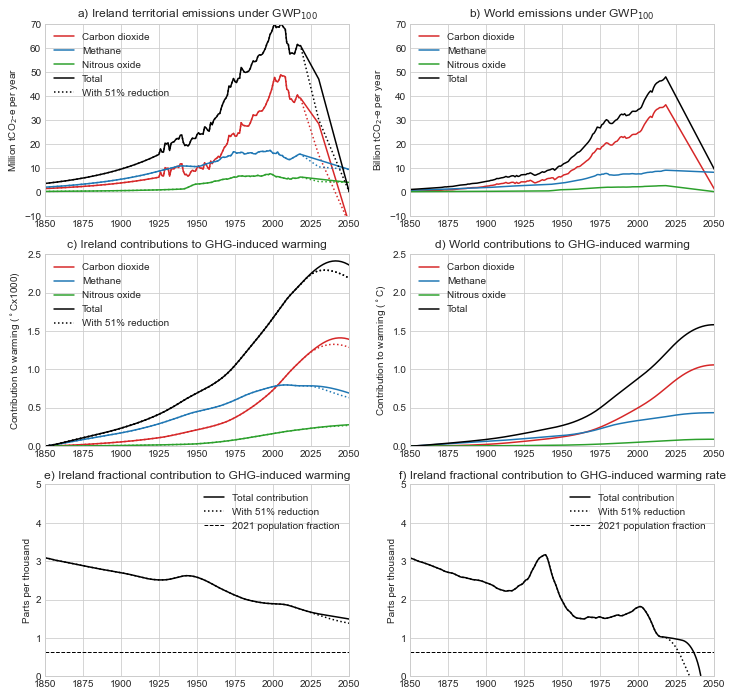

In [10]:
xrange=[1850,2050]
clab=['Carbon dioxide','Methane','Nitrous oxide','Total']

fg1 = plt.figure(figsize=[12,12])
ax1 = fg1.add_subplot(321)
ax1.axes.set_xlim(xrange)
ax1.axes.set_ylim([-10.,70.])
ax1.set_ylabel('Million tCO$_2$-e per year')
ax1.set_title('a) Ireland territorial emissions under GWP$_{100}$')
CT_co2e=np.zeros([CT_ghgs.shape[0],4,2])
for j in range(3):
    CT_co2e[:,j,:]=CT_ghgs[:,j,:]*gwp[j]
    ax1.plot(CT_year,CT_co2e[:,j,0], colors[j], label=clab[j])
    ax1.plot(CT_year,CT_co2e[:,j,1], colors[j], linestyle=':')
CT_co2e[:,3,:]=np.sum(CT_co2e[:,0:3,:],axis=1)
ax1.plot(CT_year,CT_co2e[:,3,0], colors[3], label=clab[3])
ax1.plot(CT_year,CT_co2e[:,3,1], colors[3], linestyle=':', label='With 51% reduction')
ax1.legend(loc=2)

ax2 = fg1.add_subplot(322)
ax2.axes.set_xlim(xrange)
ax2.axes.set_ylim([-10.,70.])
ax2.set_ylabel('Billion tCO$_2$-e per year')
ax2.set_title('b) World emissions under GWP$_{100}$')
GT_co2e=np.zeros([GT_ghgs.shape[0],4])
for j in range(3):
    GT_co2e[:,j]=GT_ghgs[:,j]*gwp[j]
    ax2.plot(CT_year,GT_co2e[:, j], colors[j], label=clab[j])
GT_co2e[:,3]=np.sum(GT_co2e[:,0:3],axis=1)
ax2.plot(CT_year,GT_co2e[:,3], colors[3], label=clab[3])
ax2.legend(loc=2)

ax3 = fg1.add_subplot(323)
ax3.axes.set_xlim(xrange)
ax3.axes.set_ylim([0.,2.5])
ax3.set_ylabel('Contribution to warming ($^\circ$Cx1000)')
ax3.set_title('c) Ireland contributions to GHG-induced warming')
for j in range(4):
    ax3.plot(CT_year,CT_temp[:,j,0], colors[j], label=clab[j])
    ax3.plot(CT_year,CT_temp[:,j,1], colors[j], linestyle=':')
ax3.plot(CT_year,CT_temp[:,3,1], colors[j], linestyle=':', label='With 51% reduction')

ax3.legend(loc=2)

ax4 = fg1.add_subplot(324)
ax4.axes.set_xlim(xrange)
ax4.axes.set_ylim([0.,2.5])
ax4.set_ylabel('Contribution to warming ($^\circ$C)')
ax4.set_title('d) World contributions to GHG-induced warming')
for j in range(4):
    ax4.plot(CT_year,GT_temp[:,j], colors[j], label=clab[j])
ax4.legend(loc=2)

popfrac=4986/7875
print('2021 population fraction:',popfrac)

ax5 = fg1.add_subplot(325)
ax5.axes.set_xlim(xrange)
ax5.axes.set_ylim([0.,5])
ax5.set_ylabel('Parts per thousand')
ax5.set_title('e) Ireland fractional contribution to GHG-induced warming')
for j in [3]:
    ax5.plot(CT_year,CT_temp[:,j,0]/GT_temp[:,j], colors[j], label='Total contribution')
    ax5.plot(CT_year,CT_temp[:,j,1]/GT_temp[:,j], colors[j], linestyle=':', label='With 51% reduction')
ax5.plot(CT_year,CT_year*0.+popfrac,colors[3],linewidth=1.0,linestyle="--",label='2021 population fraction')
ax5.legend(loc=1)
print('Contribution to warming 2018:',CT_temp[np.where(CT_year == 2018),3,0]/GT_temp[np.where(CT_year == 2018),3])

ax5 = fg1.add_subplot(326)
ax5.axes.set_xlim(xrange)
ax5.axes.set_ylim([0.,5])
ax5.set_ylabel('Parts per thousand')
ax5.set_title('f) Ireland fractional contribution to GHG-induced warming rate')
iplt=np.squeeze(np.where(CT_year <= CT_year[np.argmax(CT_temp[:,3,0])]))
for j in [3]:
    ax5.plot(CT_year[iplt],CT_rate[iplt,j,0]/GT_rate[iplt,j], colors[j], label='Total contribution')
    ax5.plot(CT_year[iplt],CT_rate[iplt,j,1]/GT_rate[iplt,j], colors[j], linestyle=':', label='With 51% reduction')
ax5.plot(CT_year,CT_year*0.+popfrac,colors[3],linewidth=1.0,linestyle="--",label='2021 population fraction')
ax5.legend(loc=1)
print('Contribution to warming rate 2018:',CT_rate[np.where(CT_year == 2018),3,0]/GT_rate[np.where(CT_year == 2018),3])

fg1.savefig("IRL_Primap_warming.png",dpi=600)